# Overview

Test multiple CNN models to find optimal fit.
Test model on sliding window to see performance on overall data

# Bring in imports

In [2]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


import json  
import mpl_toolkits
import os
import pickle
import glob
import re
import itertools
import time

import cv2
import argparse as ap


import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc
from keras.utils import np_utils

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import callbacks
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.optimizers import SGD

# !sudo pip install keras-vis
# from vis.visualization import visualize_activation
# from vis.utils import utils
# from keras import activations


import pyimagesearch.imutils as imutils
from pyimagesearch.helpers import pyramid
from pyimagesearch.helpers import sliding_window

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [3]:
image_data = pickle.load(open("image_data.pkl", "rb"))

In [4]:
image_tag = pickle.load(open("image_tag.pkl","rb"))

In [8]:
scene1 = mpimg.imread('shipsnet_data/scenes/lb_1.png')
scene2 = mpimg.imread('shipsnet_data/scenes/lb_2.png')
scene3 = mpimg.imread('shipsnet_data/scenes/lb_3.png')
scene4 = mpimg.imread('shipsnet_data/scenes/lb_4.png')
scene5 = mpimg.imread('shipsnet_data/scenes/sfbay_1.png')
scene6 = mpimg.imread('shipsnet_data/scenes/sfbay_2.png')
scene7 = mpimg.imread('shipsnet_data/scenes/sfbay_3.png')
scene8 = mpimg.imread('shipsnet_data/scenes/sfbay_4.png')

# Bring in helpers

In [9]:
def scan_image(model,image,stepSize,proba):
    (winW, winH) = (80, 80)
    output = []
    cnn_windows = []
    cnn_coords = []
    i = 0
    for (x, y, window) in sliding_window(image, stepSize=stepSize, windowSize=(winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        cnn_window = np.expand_dims(window, axis=0)
        y_pred = model.predict(cnn_window)
        y_pred_val = list(y_pred[0])[1]
        
        if y_pred_val > proba :
            cnn_coords.append((x,y))
            cnn_windows.append(window)
        i+=1
    output.append(cnn_windows)
    output.append(cnn_coords)
    return output

In [10]:
def plot_found(cnn_coords,image):
    fig,ax = plt.subplots(1)
    ax.imshow(image)

    for i in cnn_coords:
        rect = patches.Rectangle(i,80,80,linewidth=4,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [11]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 30, 30

# i = 1
# for image in scenes:
#     plt.subplot(4,2,i)
#     plt.imshow(globals()[image])
#     i+=1

In [12]:
def plot_learning(model_history):
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_loss(model_history):
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Make test and train

In [13]:
X = np.asarray(image_data)
y = np.asarray(image_tag)

In [14]:
X = X/ 255

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1234, stratify = y, shuffle = True)

In [16]:
# output encoding
y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [17]:
np.random.seed(42)

In [18]:
y_test[1]

array([0., 1.], dtype=float32)

## Make a rotated X_train and y_train

In [19]:
datagen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True
)  # randomly flip images

datagen.fit(X_train)

In [20]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=1000, shuffle = True):
    # Show 9 images
#     for i in range(0, 9):
#         plt.subplot(330 + 1 + i)
#         plt.imshow(X_batch[i])
#         plt.title(y_batch[i])
#     # show the plot
#     plt.show()
    break

In [21]:
X_rot = np.concatenate((X_train,X_batch))
y_rot = np.concatenate((y_train,y_batch))

In [22]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [23]:
X_rot_shuf, y_rot_shuf = unison_shuffled_copies(X_rot,y_rot)

# Run models

## final model
Model seeded from https://www.kaggle.com/byrachonok/keras-for-search-ships-in-satellite-image

In [24]:
# network design
B1 = Sequential()

B1.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
B1.add(MaxPooling2D(pool_size=(2, 2))) #40x40
B1.add(Dropout(0.25))

B1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
B1.add(MaxPooling2D(pool_size=(2, 2))) #20x20
B1.add(Dropout(0.25))

B1.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
B1.add(MaxPooling2D(pool_size=(2, 2))) #10x10
B1.add(Dropout(0.25))

B1.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
B1.add(MaxPooling2D(pool_size=(2, 2))) #5x5
B1.add(Dropout(0.25))

B1.add(Flatten())
B1.add(Dense(512, activation='relu'))
B1.add(Dropout(0.5))

B1.add(Dense(2, activation='softmax'))

In [25]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
B1.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training
B1_history = B1.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

Train on 1790 samples, validate on 448 samples
Epoch 1/18
 - 15s - loss: 0.5252 - acc: 0.7592 - val_loss: 0.4053 - val_acc: 0.8705
Epoch 2/18
 - 14s - loss: 0.3071 - acc: 0.8715 - val_loss: 0.2646 - val_acc: 0.9018
Epoch 3/18
 - 14s - loss: 0.2446 - acc: 0.8950 - val_loss: 0.2323 - val_acc: 0.8996
Epoch 4/18
 - 14s - loss: 0.2189 - acc: 0.9084 - val_loss: 0.1833 - val_acc: 0.9263
Epoch 5/18
 - 14s - loss: 0.1893 - acc: 0.9274 - val_loss: 0.1528 - val_acc: 0.9353
Epoch 6/18
 - 14s - loss: 0.1554 - acc: 0.9385 - val_loss: 0.1434 - val_acc: 0.9397
Epoch 7/18
 - 14s - loss: 0.1420 - acc: 0.9458 - val_loss: 0.1277 - val_acc: 0.9420
Epoch 8/18
 - 14s - loss: 0.1357 - acc: 0.9447 - val_loss: 0.1772 - val_acc: 0.9330
Epoch 9/18
 - 14s - loss: 0.1246 - acc: 0.9503 - val_loss: 0.1527 - val_acc: 0.9263
Epoch 10/18
 - 14s - loss: 0.1216 - acc: 0.9525 - val_loss: 0.1344 - val_acc: 0.9531
Epoch 11/18
 - 14s - loss: 0.1004 - acc: 0.9642 - val_loss: 0.1172 - val_acc: 0.9643
Epoch 12/18
 - 14s - loss: 

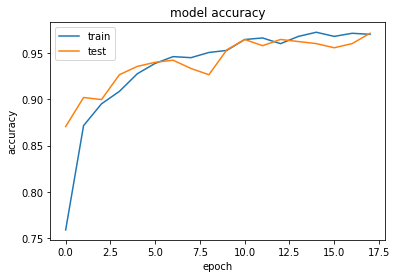

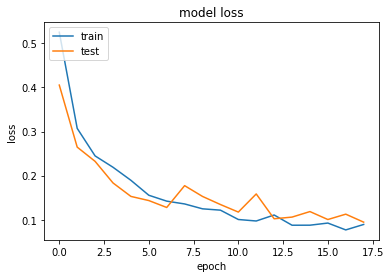

In [26]:
plot_learning(B1_history)
plot_loss(B1_history)


In [27]:
B1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 32)        9248      
__________

In [31]:
# from matplotlib import pyplot as plt
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 6)

# # Utility to search for layer index by name.
# # Alternatively we can specify this as -1 since it corresponds to the last layer.
# layer_idx = utils.find_layer_idx(B1, 'preds')

# # Swap softmax with linear
# B1.layers[layer_idx].activation = activations.linear
# B1_model = utils.apply_modifications(B1)

# # This is the output node we want to maximize.
# filter_idx = 0
# img = visualize_activation(B1_model, layer_idx, filter_indices=filter_idx)
# plt.imshow(img[..., 0])


In [30]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
y_pred = B1.predict(X_train)

In [32]:
y_pred_cutoff = []
for i in y_pred:
    if i[1] > .6:
        y_pred_cutoff.append(1)
    else: y_pred_cutoff.append(0)

In [33]:
y_test_non_category = [ np.argmax(t) for t in y_train ]



Precision:              0.97
Recall:                 0.99
Specificity:              0.92
[[1670    9]
 [  45  514]]


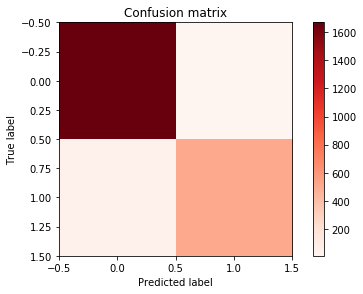

In [34]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test_non_category, y_pred_cutoff)
print ('\n')
print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))
print(conf)
plot_confusion_matrix(conf)

In [37]:
B1.evaluate(X_test, y_test, verbose=1)

560/560 [==============================] - 0s 289us/step


[0.10998725635664804, 0.9571428571428572]

In [38]:
# B1.save('final_model.h5')

## test on web image

In [39]:
# from PIL import Image
# testsc = Image.open('planet-sc.png')
# if testsc.mode == 'RGBA':
#     testsc = testsc.convert('RGB')
#     h = testsc.size[0]
#     w = testsc.size[1]
#     testsc = testsc.resize((3*h,3*w))
#     testsc = np.asarray(testsc)
    

In [40]:
test = mpimg.imread('test.jpg')


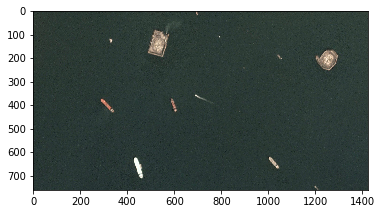

In [41]:
plt.imshow(test)

In [42]:
output = scan_image(B1,scene4,4,.4)

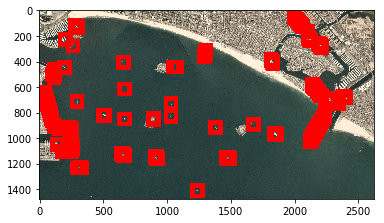

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_yticklabels'

In [53]:
plot_found(output[1],scene4)


In [46]:
output12 = scan_image(B1,scene4,12,.8)

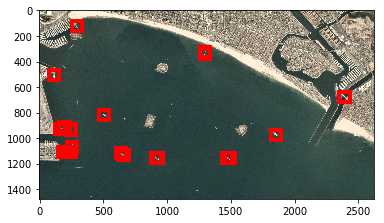

In [47]:
plot_found(output12[1],scene4)

In [50]:
output30 = scan_image(B1,scene4,20,.9)

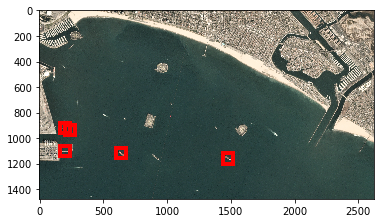

In [51]:
plot_found(output30[1],scene4)

## Cambridge Spark Model
Model from https://cambridgespark.com/content/tutorials/neural-networks-tuning-techniques/index.html

In [43]:
C1 = Sequential()

C1.add(Conv2D(32, (3, 3), input_shape=(80, 80, 3), activation='relu'))
C1.add(MaxPooling2D(pool_size=(2, 2)))
C1.add(Dropout(0.25))

C1.add(Conv2D(32, (3, 3), input_shape=(80, 80, 3), activation='relu'))
C1.add(MaxPooling2D(pool_size=(2, 2)))
C1.add(Dropout(0.25))

C1.add(Flatten())
C1.add(Dense(128, activation='relu'))
C1.add(Dropout(0.5))

C1.add(Dense(2, activation='softmax'))

In [44]:
C1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# training
C1_history = C1.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

C1.evaluate(X_test, y_test, verbose=1)

Train on 1792 samples, validate on 448 samples
Epoch 1/18
 - 2s - loss: 0.4266 - acc: 0.8153 - val_loss: 0.4432 - val_acc: 0.9241
Epoch 2/18
 - 1s - loss: 0.2727 - acc: 0.8884 - val_loss: 0.2589 - val_acc: 0.9241
Epoch 3/18
 - 1s - loss: 0.2164 - acc: 0.9185 - val_loss: 0.1340 - val_acc: 0.9420
Epoch 4/18
 - 1s - loss: 0.1675 - acc: 0.9291 - val_loss: 0.1849 - val_acc: 0.9308
Epoch 5/18
 - 1s - loss: 0.1644 - acc: 0.9425 - val_loss: 0.1600 - val_acc: 0.9509
Epoch 6/18
 - 1s - loss: 0.1454 - acc: 0.9453 - val_loss: 0.1164 - val_acc: 0.9487
Epoch 7/18
 - 1s - loss: 0.1203 - acc: 0.9542 - val_loss: 0.1326 - val_acc: 0.9554
Epoch 8/18
 - 1s - loss: 0.1009 - acc: 0.9643 - val_loss: 0.0917 - val_acc: 0.9732
Epoch 9/18
 - 1s - loss: 0.1054 - acc: 0.9609 - val_loss: 0.1062 - val_acc: 0.9621
Epoch 10/18
 - 1s - loss: 0.0884 - acc: 0.9682 - val_loss: 0.0857 - val_acc: 0.9754
Epoch 11/18
 - 1s - loss: 0.0777 - acc: 0.9721 - val_loss: 0.0927 - val_acc: 0.9665
Epoch 12/18
 - 1s - loss: 0.0666 - acc

[0.08434663391006844, 0.9678571428571429]

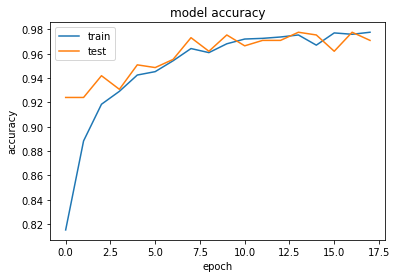

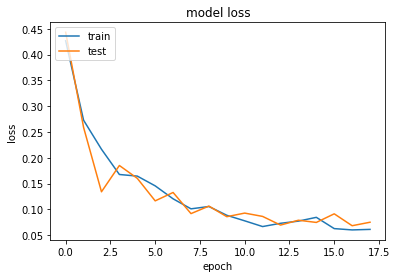

In [45]:
plot_learning(C1_history)
plot_loss(C1_history)

In [46]:
C1_output = scan_image(C1,scene1,12,.9)
plot_found(C1_output[1],scene1)

KeyboardInterrupt: 

### With rotation

In [ ]:
C1.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                 shuffle=True, 
                 epochs=18,
                 validation_split=0.2,
                 shuffle=True,
                 verbose=1)

C1.evaluate(X_test, y_test, verbose=1)

## Paul M Model
model from https://www.kaggle.com/rhammell/ships-in-satellite-imagery

In [ ]:
P1 = Sequential()

P1.add(Conv2D(32, (3, 3), input_shape=(80, 80, 3), activation='relu'))
P1.add(Conv2D(64, (3, 3), activation='relu'))
P1.add(MaxPooling2D(pool_size=(2, 2))) #40x40
P1.add(Dropout(0.25))
P1.add(Flatten())

P1.add(Dense(128, activation='relu'))
P1.add(Dropout(0.5))
P1.add(Dense(2, activation='softmax'))

In [ ]:
P1.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy'])

# training
P1_history = P1.fit(
    X_train, 
    y_train,
    batch_size=32,
    epochs=18,
    validation_split=0.2,
    shuffle=True,
    verbose=2)

P1.evaluate(X_test, y_test, verbose=1)

In [ ]:
plot_learning(P1_history)
plot_loss(P1_history)

In [ ]:
P1_output = scan_image(P1,scene2,12,.9)
plot_found(P1_output[1],scene2)